In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Equation:
    
    def __init__(self, a, f, X, T, left_cond, is_left_cond_der, right_cond, is_right_cond_der, start_cond):
        self.a = a
        self.f = f
        self.X = X
        self.T = T
        self.left_cond = left_cond
        self.is_left_cond_der = is_left_cond_der
        self.right_cond = right_cond
        self.is_right_cond_der = is_right_cond_der
        self.start_cond = start_cond
        
    def __split(self, N_x, N_t):
        x_splitting = np.zeros(N_x)
        t_splitting = np.zeros(N_t)
        for i in range(N_x):
            x_splitting[i] = i*self.X/(N_x-1)
        for i in range(N_t):
            t_splitting[i] = i*self.T/(N_t-1)
        return x_splitting, t_splitting
    
    def __solve_system(self, A, b):
        N = len(b)
        alpha = np.zeros(N-1)
        beta = np.zeros(N-1)
        beta[0] = b[0]/A[0,0]
        alpha[0] = -A[0,1]/A[0,0]
        
        for i in range (1, N-1):
            alpha[i] = -A[i,i+1]/(A[i,i-1]*alpha[i-1] + A[i,i])
            beta[i] = (b[i] - A[i,i-1]*beta[i-1]) /(A[i,i-1]*alpha[i-1] + A[i,i])
            
        y = np.zeros(N)
        y[N-1] = (b[N-1] - A[N-1,N-2]*beta[N-2]) / (A[N-1,N-2]*alpha[N-2] + A[N-1,N-1])
        
        for i in range (N-2, -1, -1):
            y[i] = alpha[i] * y[i+1] + beta[i]
            
        return y
    
    def __two_layer_method(self, x, t, y_0,n):
        N = len(x)
        h = self.X/(N-1)
        tau = self.T/(len(t)-1)
        A = np.zeros((N,N))
        b = np.zeros(N)
        
        if self.is_left_cond_der:
            A[0,0] = 1/h
            A[0,1] = -1/h
        else:
            A[0,0] = 1
        b[0] = self.left_cond(t[n])
        
        for i in range(1,N-1):
            A[i,i-1] = -self.a/(2*h*h)
            A[i,i] = 1/tau + self.a/(h*h)
            A[i,i+1] = -self.a/(2*h*h)
            b[i] = self.a/(2*h*h)*y_0[i-1] + (1/tau - self.a/(h*h))*y_0[i] + \
            self.a/(2*h*h)*y_0[i+1] + 1/2*(self.f(x[i],t[n]) + self.f(x[i],t[n-1]))
        
        if self.is_right_cond_der:
            A[N-1,N-2] = 1/h
            A[N-1,N-1] = -1/h
        else:
            A[N-1,N-1] = 1
        b[N-1] = self.right_cond(t[n])
       
        return self.__solve_system(A,b)
    
    def __three_layer_method(self, x, t, y_0, y_1, n):
        N = len(x)
        h = self.X/(N-1)
        tau = self.T/(len(t)-1)
        A = np.zeros((N,N))
        b = np.zeros(N)
        
        if self.is_left_cond_der:
            A[0,0] = 1/h
            A[0,1] = -1/h
        else:
            A[0,0] = 1
        b[0] = self.left_cond(t[n])
        
        for i in range(1,N-1):
            A[i,i-1] = -self.a/(h*h)
            A[i,i] = 3/(2*tau) + 2*self.a/(h*h)
            A[i,i+1] = -self.a/(h*h)
            b[i] = 2/tau* y_1[i] - y_0[i]/(2*tau) + self.f(x[i],t[n])
        
        if self.is_right_cond_der:
            A[N-1,N-2] = 1/h
            A[N-1,N-1] = -1/h
        else:
            A[N-1,N-1] = 1
        b[N-1] = self.right_cond(t[n])
        
        return self.__solve_system(A,b)
    
    
    def solve(self, Nx, Nt):
        x, t = self.__split(Nx, Nt)
        y_0 = self.start_cond(x)
        y_1 = self.__two_layer_method(x,t,y_0, 1)
        y_2 = self.__three_layer_method(x, t, y_0, y_1, 2)
        for n in range (3, Nt):
            y_0 = y_1.copy()
            y_1 = y_2.copy()
            y_2 = self.__three_layer_method(x, t, y_0, y_1, n)
        return y_2
    
    def solve_2(self, Nx, Nt):
        x, t = self.__split(Nx, Nt)
        y_0 = self.start_cond(x)
        for n in range (1, Nt):
            y_1 = self.__two_layer_method(x, t, y_0, n)
            y_0 = y_1.copy()
        return y_1
        

In [4]:
def norm(f_1, f_2):
    return np.max(np.abs(f_1 - f_2))

def split_x(X, N):
    res = np.zeros(N)
    for i in range(N):
        res[i] = X*i/(N-1)
    return res

error norm= 0.03138889423589086


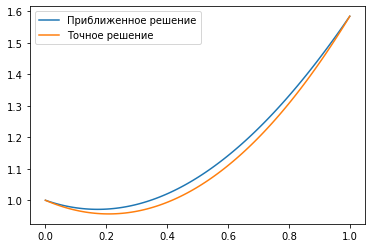

In [8]:
N = 100
x = split_x(1, N)
u_accuracy = lambda x: x*x + 1 + x * np.cos(2)
u_ac_h = u_accuracy(x)

eq = Equation(a=1, f=lambda x,t: 2*t-2*x*np.sin(2*t)-2, X=1,T=1,left_cond=lambda t: t*t, is_left_cond_der=False, \
              right_cond=lambda t: 1+t*t+np.cos(2*t), is_right_cond_der=False, start_cond=lambda x: x*x+x)
u_h = eq.solve(N,3)
plt.plot(x, u_h, label='Приближенное решение')
plt.plot(x, u_ac_h, label = 'Точное решение')
plt.legend()
print('error norm=', norm(u_h, u_ac_h))

error norm= 4.440892098500626e-16


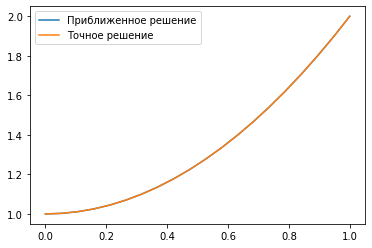

In [9]:
eq1 = Equation(a=1, f=lambda x,t: -1 + x*0, X=1,T=1,left_cond=lambda t: t, is_left_cond_der=False, \
              right_cond=lambda t: 1+t, is_right_cond_der=False, start_cond=lambda x: x*x)

x = split_x(1, 20)
u_accuracy = lambda x: x*x+1
u_ac_h = u_accuracy(x)

u_h = eq1.solve(20,40)
plt.plot(x, u_h, label='Приближенное решение')
plt.plot(x, u_ac_h, label = 'Точное решение')
plt.legend()
print('error norm=', norm(u_h, u_ac_h))